In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

In [3]:
data_user = pd.read_pickle('/kaggle/input/ncf-data/data_user.pkl')
data_item = pd.read_pickle('/kaggle/input/ncf-data/data_item.pkl')
data_rec = pd.read_pickle('/kaggle/input/ncf-data/data_rec.pkl')

In [10]:
data_rec.head()

,app_id,is_recommended,hours,user_id
0,1325200,1,0.0945,11593837
1,1325200,1,0.0945,11593837
2,1325200,1,0.0945,11593837
3,1325200,1,0.0945,11593837
4,536270,0,0.0007,1663073


In [11]:
data_user['idx_user'] = [i for i in range(len(data_user))]
data_item['idx_item'] = [i for i in range(len(data_item))]

In [12]:
data = pd.merge(data_rec,data_user[['idx_user','user_id']],on ='user_id')
data = pd.merge(data,data_item[['idx_item','app_id']], on = 'app_id')

In [13]:
del data['app_id']
del data['user_id']

In [15]:
data.head()

,is_recommended,hours,idx_user,idx_item
0,1,0.0945,22839,22940
1,1,0.0945,22839,22941
2,1,0.0945,22839,22942
3,1,0.0945,22839,22943
4,1,0.0945,22839,22940


In [16]:
data['hours'] = data['hours'].apply(lambda x: x*10000)


In [17]:
data.head()

,is_recommended,hours,idx_user,idx_item
0,1,945.0,22839,22940
1,1,945.0,22839,22941
2,1,945.0,22839,22942
3,1,945.0,22839,22943
4,1,945.0,22839,22940


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

  with pd.option_context('mode.use_inf_as_na', True):


NameError: name 'plt' is not defined

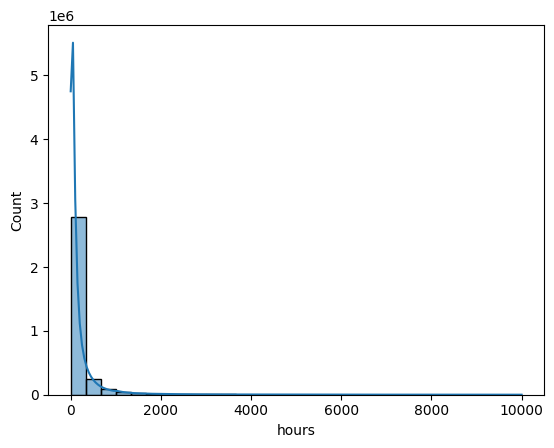

In [10]:
import seaborn as sns

sns.histplot(data['hours'], bins=30, kde=True)
plt.title('Distribute of  attribute hours')
plt.xlabel('value')
plt.ylabel('frequecy')
plt.show()

In [ ]:
data[:20]

* train test split


In [12]:
# train with 60 percent
data_train = pd.DataFrame()
data_test = pd.DataFrame() 
for key, val in data.groupby('idx_item'): 
  a = int(len(val)*0.8) 
  val['id_item'] = [key for i in range(len(val))] 
  data_train = pd.concat([data_train, val[:a]], axis=0) 
  data_test = pd.concat([data_test,val[a:]], axis = 0) 

In [13]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
# data user
def transform(data):
  tensor_id_user  = torch.Tensor(np.stack(data['idx_user'].values))
  tensor_id_item  = torch.Tensor(np.stack(data['idx_item'].values))
  tensor_rating  = torch.Tensor(np.stack(data['rating'].values))
  tensor_rec = torch.Tensor(np.stack(data['is_recommended'].values))

  dataset = TensorDataset(tensor_id_user, tensor_id_item, tensor_rating,tensor_rec)
  dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
  return dataloader

In [14]:
data_train.head()

,is_recommended,hours,idx_user,idx_item,rating,id_item
15124,1,195.0,0,13839,5.0,0
73260,1,253.0,0,16522,5.0,0
103924,1,172.0,0,46654,5.0,0
121375,1,69.0,0,16209,4.5,0
177489,1,63.0,0,1843,4.5,0


* transform data

In [15]:
dataloader_train , dataloader_test = transform(data_train), transform(data_test)

In [ ]:
for batch in dataloader_train:
    print(batch)
    if True:
        break

# learning implicit data

In [4]:
class NCF(nn.Module):
    def __init__(self,embed_dim,num_user,num_item):
        super(NCF,self).__init__()
        self.relu = nn.ReLU()
        self.embedding_user = nn.Embedding(num_embeddings = num_user,embedding_dim = embed_dim)
        self.embedding_item = nn.Embedding(num_embeddings = num_item,embedding_dim = embed_dim)
        self.dense1 = nn.Linear(in_features =embed_dim*2, out_features = 64)
        self.dense2 = nn.Linear(in_features = 64, out_features = 32)
        self.dense3 = nn.Linear(in_features = 32, out_features = 16)
        self.dense4 = nn.Linear(in_features = 16, out_features = 1)
        
        self.softmax = nn.Softmax(dim=1) 
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, user, item):
        user_embed = self.embedding_user(user)
        item_embed = self.embedding_item(item)
        concat_features = torch.cat((user_embed,item_embed), dim = 1)
        x = self.dense1(concat_features)
        x = self.relu(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dense4(x)
        x = self.sigmoid(x)
        return x

In [5]:
num_user = len(data_user)
num_item = len(data_item)
num_embed = 8

In [18]:
model = NCF(num_embed,num_user, num_item)

In [ ]:
print(model)

In [19]:
epoch = 50
learning_rate = 0.002
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr= learning_rate)

In [20]:
device = ('cuda' if torch.cuda.is_available()
            else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [25]:
#  evaluation matrix in total data
from sklearn.metrics import ndcg_score, f1_score

# evaluation metric
user = data_user['idx_user'].unique()
# ndcg, f1
def metric(model,k):
    a = np.random.randint(0,len(user)-500)
    user_eval = user[a:a+500]
    ndcg = 0
    f1_score_total = 0
    for u in user_eval:
        item = list(data[data['idx_user'] == u]['idx_item'])
        actual = list(data[data['idx_user'] == u]['is_recommended'])
        s = predict(model,u,item)
        ndcg += ndcg_score([actual],[s])
        a = f1_score(np.array(actual),(np.array(s) >= 0.9).astype(int))
        f1_score_total += a
    result_ndcg = ndcg/len(user_eval)
    result_f1 = f1_score_total/len(user_eval)
    return result_ndcg,result_f1
    
def predict(model,u_idx,item):
    score = []
    for i in item:
        predict = model(torch.Tensor([u_idx]).long(),torch.Tensor([i]).long())
        score.append(predict.item())
    return score

* loop train

In [26]:
for i in range(epoch):
    model.train()
    total_loss_train = 0
    for batch in dataloader_train:
        id_user,id_item,_,rec = batch
        id_user,id_item,rec = id_user.to(device), id_item.to(device), rec.to(device)
    
        output = model(id_user.long(),id_item.long())
        loss = loss_function(output.reshape(-1),rec.float())
        total_loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    #evaluation
    model.eval()
    ndcg,f1 = metric(model,k=10)
    print(f'Epoch{i +1}/{epoch}, loss_train : {total_loss_train/len(dataloader_train)},metric_ndcg:{ndcg},metric_f1score:{f1}')

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch1/50, loss_train : 0.3142169406747421,metric_ndcg:0.967810035757654,metric_f1score:0.6638640591614469


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch2/50, loss_train : 0.31106204703587587,metric_ndcg:0.9726706941634373,metric_f1score:0.6716793264795737

Epoch3/50, loss_train : 0.3080647982146561,metric_ndcg:0.9749700490848541,metric_f1score:0.6375242933542614

Epoch4/50, loss_train : 0.30498657133376694,metric_ndcg:0.9734914434012195,metric_f1score:0.6465070714819163

Epoch5/50, loss_train : 0.3018874040447213,metric_ndcg:0.9702549536290753,metric_f1score:0.59491353194807

Epoch6/50, loss_train : 0.29882077735072143,metric_ndcg:0.9729696760672368,metric_f1score:0.6509166982271999

Epoch7/50, loss_train : 0.2960581142528095,metric_ndcg:0.9730917954903747,metric_f1score:0.6879341525429683


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch8/50, loss_train : 0.2932753211057752,metric_ndcg:0.9767103717166142,metric_f1score:0.694233009852809


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch9/50, loss_train : 0.2906251902742524,metric_ndcg:0.9696427662432296,metric_f1score:0.6651683223075374

Epoch10/50, loss_train : 0.28809309408587175,metric_ndcg:0.9782521693699804,metric_f1score:0.7001285176975329

Epoch11/50, loss_train : 0.28582298800111394,metric_ndcg:0.9780031009797884,metric_f1score:0.7157135704451512


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch12/50, loss_train : 0.283559480208737,metric_ndcg:0.9748017691790128,metric_f1score:0.7113871370115484

Epoch13/50, loss_train : 0.28145603801162483,metric_ndcg:0.9766873908125117,metric_f1score:0.7206908304763386

Epoch14/50, loss_train : 0.27949579557324705,metric_ndcg:0.9776992633098514,metric_f1score:0.7138773886872084

Epoch15/50, loss_train : 0.277597647997531,metric_ndcg:0.9806551948512955,metric_f1score:0.7332270724077412

Epoch16/50, loss_train : 0.275912373024526,metric_ndcg:0.9784405224535715,metric_f1score:0.7013259890455352


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch17/50, loss_train : 0.2743211800995721,metric_ndcg:0.9759085346754661,metric_f1score:0.6772748712456509

Epoch18/50, loss_train : 0.27273546233573803,metric_ndcg:0.9785607958676136,metric_f1score:0.7261799082112104

Epoch19/50, loss_train : 0.27131105934745126,metric_ndcg:0.9795507922346516,metric_f1score:0.7426653058481028

Epoch20/50, loss_train : 0.26999895343331903,metric_ndcg:0.9795862416956687,metric_f1score:0.7243195887340498

Epoch21/50, loss_train : 0.2687267131451231,metric_ndcg:0.9817499204958281,metric_f1score:0.7267517553320211

Epoch22/50, loss_train : 0.2674657164485554,metric_ndcg:0.9808286453900579,metric_f1score:0.7296495960190672

Epoch23/50, loss_train : 0.26644625470206207,metric_ndcg:0.9788570003874015,metric_f1score:0.7297938138886565

Epoch24/50, loss_train : 0.26527268515979735,metric_ndcg:0.9809906632794596,metric_f1score:0.712124309975353

Epoch25/50, loss_train : 0.26427889782302005,metric_ndcg:0.9765987405774634,metric_f1score:0.7206544989856861


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch26/50, loss_train : 0.26312920501095766,metric_ndcg:0.9752107161022457,metric_f1score:0.7342894564726807

Epoch27/50, loss_train : 0.2622965569448646,metric_ndcg:0.9831592022369615,metric_f1score:0.7557174662848761


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch28/50, loss_train : 0.26135467189774353,metric_ndcg:0.9809158954087647,metric_f1score:0.7368519769357894

Epoch29/50, loss_train : 0.26061541843198033,metric_ndcg:0.9770947712334118,metric_f1score:0.73615143706859


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch30/50, loss_train : 0.25973347913726086,metric_ndcg:0.9762259488510088,metric_f1score:0.7396078380457628

Epoch31/50, loss_train : 0.2590186709326299,metric_ndcg:0.9824095784400613,metric_f1score:0.7776770691109464

Epoch32/50, loss_train : 0.25838270061928675,metric_ndcg:0.9824425596293881,metric_f1score:0.7423851445638378

Epoch33/50, loss_train : 0.2576154845225583,metric_ndcg:0.9812912081387999,metric_f1score:0.7400682709191228


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch34/50, loss_train : 0.2568726734492473,metric_ndcg:0.9783307472494318,metric_f1score:0.7279831864524101


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch35/50, loss_train : 0.2562376802588308,metric_ndcg:0.9744067420887709,metric_f1score:0.7274594919147106

Epoch36/50, loss_train : 0.2554765305079943,metric_ndcg:0.9806976992695563,metric_f1score:0.7419673971003957

Epoch37/50, loss_train : 0.2549379440900697,metric_ndcg:0.9755367502741774,metric_f1score:0.7076709726198537

Epoch38/50, loss_train : 0.2544390468891329,metric_ndcg:0.9814015831527964,metric_f1score:0.7551474550910695

Epoch39/50, loss_train : 0.25381042875731397,metric_ndcg:0.9805731376562925,metric_f1score:0.7410892482872379


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch40/50, loss_train : 0.253375902689223,metric_ndcg:0.9775031421136527,metric_f1score:0.7137742090831003

Epoch41/50, loss_train : 0.2529004642355249,metric_ndcg:0.9813430743409806,metric_f1score:0.7490257159909773


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch42/50, loss_train : 0.25235579515089657,metric_ndcg:0.9797043656540693,metric_f1score:0.7489535026163615

Epoch43/50, loss_train : 0.25187817009988905,metric_ndcg:0.9800637335371963,metric_f1score:0.7454925977506679

Epoch44/50, loss_train : 0.25149324997525346,metric_ndcg:0.983892429080669,metric_f1score:0.7746101358809913

Epoch45/50, loss_train : 0.2509180008655995,metric_ndcg:0.9820906015751352,metric_f1score:0.7688368033686576


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Epoch46/50, loss_train : 0.2505748441945671,metric_ndcg:0.9788116350196172,metric_f1score:0.7532755615144763

Epoch47/50, loss_train : 0.25020814877654535,metric_ndcg:0.9825033202402405,metric_f1score:0.7825377824080978

Epoch48/50, loss_train : 0.24968508908199558,metric_ndcg:0.9825664556530721,metric_f1score:0.7896550451259974

Epoch49/50, loss_train : 0.24928926028509946,metric_ndcg:0.9808966871864518,metric_f1score:0.7681231444915025

Epoch50/50, loss_train : 0.24890765074141566,metric_ndcg:0.9802318838531153,metric_f1score:0.7207226868064706


* save model

In [ ]:
torch.save(model.state_dict(), 'model_NCF_implicit_1.pth')

# evaluation in test and comapare performance with NeuMF


In [5]:
neumf = [0.28172174323606125,0.2712961802994211,0.26158550698829025,0.2524581143324706,0.24400598435923332,0.23605456829212862,0.22869432667704065,0.22181735237035688,0.2155287012751823,0.20957054254958352,0.20421548192312214,0.19912319106177342,0.19452021914412673,0.19007100469132795,0.18596994924946514,0.1821484308144353,0.17855054625741457,0.1752165375085171,0.1721914964801459,0.16925187578218548,0.16650270287893307,0.16389539197591035,0.16137376892028366,0.15885944115970208,0.1567266069244048,0.15461478968010298,0.15247679155168878,0.15065345159656374,0.14862697224912988,0.14698128574112782,0.14538948221572198,0.14380462866679428,0.14221430691983025,0.1406639507449399,0.13918448041759257,0.13801014411404525,0.1365915853018666,0.1352050009166874,0.13413599161374873,0.13293248587796233,0.13171142594460583,0.1305864035024762,0.1296144597534442,0.12851299438191627,0.127583197179801,0.12662925723398347,0.12563357158241156,0.12479725217459058,0.1238996316040367,0.12302231631897552]
ncf = [0.3142169406747421,0.31106204703587587,0.3080647982146561,0.30498657133376694,0.3018874040447213,0.29882077735072143,0.2960581142528095,0.2932753211057752,0.2906251902742524,0.28809309408587175,0.28582298800111394,0.283559480208737,0.28145603801162483,0.27949579557324705,0.277597647997531,0.275912373024526,0.2743211800995721,0.27273546233573803,0.27131105934745126,0.26999895343331903,0.2687267131451231,0.2674657164485554,0.26644625470206207,0.26527268515979735,0.26427889782302005,0.26312920501095766,0.2622965569448646,0.26135467189774353,0.26061541843198033,0.25973347913726086,0.2590186709326299,0.25838270061928675,0.2576154845225583,0.2568726734492473,0.2562376802588308,0.2554765305079943,0.2549379440900697,0.2544390468891329,0.25381042875731397,0.253375902689223,0.2529004642355249,0.25235579515089657,0.25187817009988905,0.25149324997525346,0.2509180008655995,0.2505748441945671,0.25020814877654535,0.24968508908199558,0.24928926028509946,0.24890765074141566]

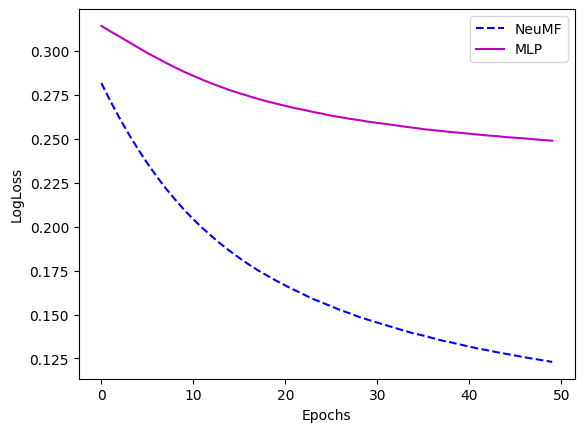

In [19]:
plt.plot(neumf, 'b--', label='NeuMF')  # Đường nét đứt màu xanh dương
plt.plot(ncf, 'm-', label='MLP')   # Đường liền màu tím

plt.xlabel('Epochs')
plt.ylabel('LogLoss')
plt.legend()
plt.show()

In [21]:
ncf_f1 = [0.6638640591614469,0.6716793264795737,0.6375242933542614,0.6465070714819163,0.59491353194807,0.6509166982271999,0.6879341525429683,0.694233009852809,0.6651683223075374,0.7001285176975329,0.7157135704451512,0.7113871370115484,0.7206908304763386,0.7138773886872084,0.7332270724077412,0.7013259890455352,0.6772748712456509,0.7261799082112104,0.7426653058481028,0.7243195887340498,0.7267517553320211,0.7296495960190672,0.7297938138886565,0.712124309975353,0.7206544989856861,0.7342894564726807,0.7557174662848761,0.7368519769357894,0.73615143706859,0.7396078380457628,0.7776770691109464,0.7423851445638378,0.7400682709191228,0.7279831864524101,0.7274594919147106,0.7419673971003957,0.7076709726198537,0.7551474550910695,0.7410892482872379,0.7137742090831003,0.7490257159909773,0.7489535026163615,0.7454925977506679,0.7746101358809913,0.7688368033686576,0.7532755615144763,0.7825377824080978,0.7896550451259974,0.7681231444915025,0.7207226868064706]
neumf_f1 = [0.7158609192801563,0.733624821607788,0.7601551949334521,0.7346033142334074,0.7692880274815417,0.800454321351614,0.7973937560351408,0.7959538599422232,0.8183383437119708,0.8342547643102113,0.8226466379672238,0.8188031061188297,0.8323626299648299,0.8549448738214221,0.8632169914748283,0.8445282077466123,0.8483194250869737,0.859103337187996,0.86883898347539,0.8716065314564828,0.8718159797133881,0.848461565072048,0.8717943627237981,0.8606602773254973,0.87430475367665,0.8758279629554605,0.8715280133129312,0.8858477609067115,0.8760716793673882,0.8877304045083858,0.8928911048758261,0.8964170774980135,0.8903816068837117,0.8965856560896465,0.891212426374695,0.886136173539207,0.8927759905076538,0.8885157999749084,0.8874739444805576,0.8960913262407891,0.8956695949414242,0.8906080013566764,0.8813071677500381,0.9024554237648179,0.8923825338886615,0.8966533890480686,0.8997055129158141,0.9067247018885041,0.9028410887146398,0.8979786584085819]

In [23]:
print(len(ncf_f1))
print(len(neumf_f1))

50

50


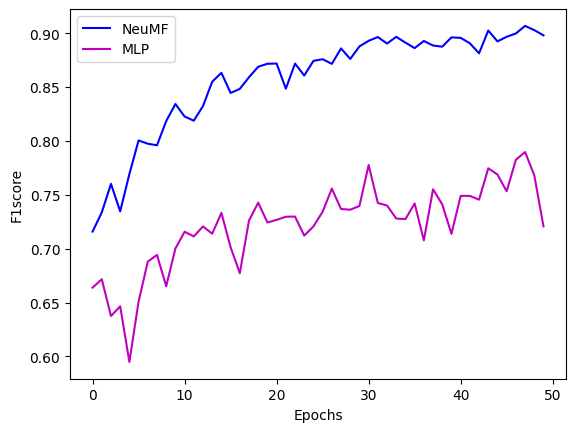

In [24]:
plt.plot(neumf_f1, 'b-', label='NeuMF')  # Đường nét đứt màu xanh dương
plt.plot(ncf_f1, 'm-', label='MLP')   # Đường liền màu tím

plt.xlabel('Epochs')
plt.ylabel('F1score')
plt.legend()
plt.show()

In [7]:
model_2 = NCF(num_embed,num_user, num_item)
model_2.load_state_dict(torch.load('/kaggle/input/model-evalu/model_NCF_implicit.pth'))

<All keys matched successfully>

In [10]:
from sklearn.metrics import ndcg_score, f1_score
def metric_2(model,k = 10):
    user = list(data_test['idx_user'].unique())
    a = np.random.randint(0,len(user)-500)
    user_eval = user[a:a+500]
    ndcg = 0
    f1 = 0
    for u in user_eval:
        u_interac_item = list(data_test[data_test['idx_user'] == u]['idx_item'])
        score = predict_2(model,u,u_interac_item)
        score_item = {u_interac_item[i]:score[i] for i in range(len(score))}
        score_item = dict(sorted(score_item.items(), key=lambda item: item[1]))
        new_item = list(score_item.keys())[:k]
        new_score = list(score_item.values())[:k]
        actual = list(data_test[(data_test['idx_item'].isin(new_item)) & (data_test['idx_user'] == u)]['is_recommended'])
        ndcg += ndcg_score([actual],[new_score])
        f1 += f1_score(np.array(actual),np.array([1 if new_score[i]>= 0.7 else 0 for i in range(len(new_score))]))
    result_ndcg = ndcg/len(user_eval)
    result_f1 = f1/len(user_eval)
    return result_ndcg,result_f1
    
def predict_2(model,u_idx,item):
    model.eval()
    score = []
    for i in item:
        predict = model(torch.Tensor([u_idx]).long(),torch.Tensor([i]).long())
        score.append(predict.item())
    return score

In [12]:
for i in range(4): 
    ndcg,f1 = metric_2(model_2,k=10) 
    print('evaluation '+ str(i+1) + ' ndcg@10: '+ str(ndcg) + ' f1@10: ' + str(f1))

evaluation 1 ndcg@10: 0.9185297092819348 f1@10: 0.5133282916601807
evaluation 2 ndcg@10: 0.9137835029201242 f1@10: 0.4985247364262849


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


evaluation 3 ndcg@10: 0.9153134834666556 f1@10: 0.5190953243007431
evaluation 4 ndcg@10: 0.9135810907124283 f1@10: 0.49774614647478443
